# 프로젝트: 퍼스널 컬러 진단하기 - 피부 영역 검출하기

## 데이터  
연예인 사진  

## 목표  
1. OpenCV CVTcolor와 bitwise_and 함수를 활용한 Face Detection  
1) 이미지 데이터의 기본 색상공간 RGB을 YCbCr 또는 HSV로 변환  
2) OpenCV의 CVTColor 함수 활용  
3) YCbCr Mask 생성  
4) 생성한 Mask를 원본 이미지에 입힘  
5) Face Detection된 얼굴 피부 영역의 숫자 픽셀값 도출  

2. Semantic Segmentation을 통한 얼굴 피부 영역 검출  
1) 대표적인 Model: DeepLab v3+, R-CNN, U-NET, FCN  

## (1) 라이브러리 및 데이터 불러오기

In [63]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [64]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf) #inf = infinity

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
celebrity_picture_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/train data/0703 updated/연예인"

def count_files_in_directory(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

file_count = count_files_in_directory(celebrity_picture_path)
print("파일 개수:", file_count)
# 파일 개수 290개

파일 개수: 290


## (2) Skin Detection

In [67]:
def Skin_Detection(img_path):

  #Open a simple image
  img=cv2.imread(img_path)

  #converting from gbr to hsv color space
  img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  #skin color range for hsv color space
  HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255))
  HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

  #converting from gbr to YCbCr color space
  img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  #skin color range for hsv color space
  YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
  YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

  #merge skin detection (YCbCr and hsv)
  global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
  global_mask=cv2.medianBlur(global_mask,3)
  global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


  HSV_result = cv2.bitwise_not(HSV_mask)
  YCrCb_result = cv2.bitwise_not(YCrCb_mask)
  global_result=cv2.bitwise_not(global_mask)


  #show results
  # cv2.imshow(HSV_result)
  # plt.show()
  # cv2.imshow(YCrCb_result)
  # plt.show()
  # cv2.imshow(global_result)
  # plt.show()
  # cv2.imshow(img)
  # plt.show()
  # cv2.imwrite("1_HSV.jpg",HSV_result)
  # cv2.imwrite("2_YCbCr.jpg",YCrCb_result)
  # cv2.imwrite("3_global_result.jpg",global_result)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

  return img_HSV, img_YCrCb, HSV_mask, YCrCb_mask, global_mask

In [68]:
# skin 좌표 추출, YCrCb 혹은 HSV 픽셀값 추출
def coordinate_extraction(mask, img):
  skin = np.argwhere(mask == 255) # mask의 픽셀값이 255인 skin부분의 좌표 추출

  pixel_values = [] # YCbCr 혹은 HSV 픽셀값 저장을 위한 리스트

  for index in skin:
    y, x = index  #일반적으로 생각하는 가로 x, 세로 y로 표현하기 위해 위치 바꿈
    #print(f"x: {x}, y: {y}") # skin 범위 좌표값 출력(스압주의)
    pixel_value = img[y, x]
    pixel_values.append(pixel_value)

  for coord, pixel_value in zip(skin, pixel_values): # skin부분의 좌표값과 픽셀값 출력을 위한 함수
    x, y = coord
    #print(f"Coordinate: ({x}, {y}), Pixel Value: {pixel_value}")

  return pixel_values

In [69]:
# 픽셀의 평균값 구하기
def pixel_means(pixel_values):
  # 열 별로 원소들을 더하기
  column_sums = np.sum(pixel_values, axis=0)

  # pixel_values를 NumPy 배열로 변환
  pixel_values = np.array(pixel_values)

  # 열 별로 평균 계산하기
  column_means = column_sums / pixel_values.shape[0]

  return column_means

In [73]:
def get_dict(dir_path):
  file_list = os.listdir(dir_path)

  img_list = []
  result_list = []

  for file in file_list:
    img_path = os.path.join(dir_path, file)
    if os.path.isdir(img_path):  # 만약 디렉토리인 경우, 무시하고 다음 파일로 넘어감
      continue
    img_HSV, img_YCrCb, HSV_mask, YCrCb_mask, global_mask = Skin_Detection(img_path)
    img_list.append([img_HSV, img_YCrCb, HSV_mask, YCrCb_mask, global_mask])

    # HSV
    HSV_pixel_values = coordinate_extraction(HSV_mask, img_HSV)
    HSV_pixel_means = pixel_means(HSV_pixel_values)
    #print(HSV_pixel_means)

    # YCrCb
    YCrCb_pixel_values = coordinate_extraction(YCrCb_mask, img_YCrCb)
    YCrCb_pixel_means = pixel_means(YCrCb_pixel_values)
    #print(YCrCb_pixel_means)

    # HSV + YCrCb
    global_HSV_pixel_values = coordinate_extraction(global_mask, img_HSV)
    global_HSV_pixel_means = pixel_means(global_HSV_pixel_values)
    #print(global_HSV_pixel_means)

    global_YCrCb_pixel_values = coordinate_extraction(global_mask, img_YCrCb)
    global_YCrCb_pixel_means = pixel_means(global_YCrCb_pixel_values)
    #print(global_YCrCb_pixel_means)

    result_list.append([HSV_pixel_means, YCrCb_pixel_means, global_HSV_pixel_means, global_YCrCb_pixel_means])

  return result_list

In [74]:
result_list, global_HSV_pixel_means,  = get_dict(celebrity_picture_path) # 10분

<ipython-input-69-6ce6320b7ae6>:10: RuntimeWarning: invalid value encountered in double_scalars
  column_means = column_sums / pixel_values.shape[0]


In [75]:
print(result_list)

[[array([  7.74326635, 101.92988457, 206.80429671]), array([160.28768921, 148.03123633, 117.1546942 ]), array([ 17.5888642 ,  95.51624549, 207.31741183]), array([167.30422105, 156.54901416, 107.29366843])], [array([ 13.9567604 ,  82.50924499, 160.05190678]), array([127.7213192 , 144.37840597, 109.82724774]), array([ 14.38477671,  90.66802369, 168.47150259]), array([143.7161362 , 145.6604984 , 109.06229953])], [array([ 11.10617114,  90.02737962, 137.64483735]), array([ 98.35727508, 148.85204554, 108.33427434]), array([ 15.86546755,  96.61722941, 141.72094246]), array([118.13958136, 144.83023036, 112.26590933])], [array([  6.39254207,  34.11249543, 208.83925247]), array([181.64293818, 140.04820852, 122.33685647]), array([ 10.11368979,  34.25772868, 208.77972603]), array([193.08459567, 139.21270879, 121.3918692 ])], [array([ 10.06687204,  74.81594359, 178.65598873]), array([156.79486437, 145.71419339, 114.39531967]), array([ 10.16325667,  72.29796329, 190.49705981]), array([165.19257596, 

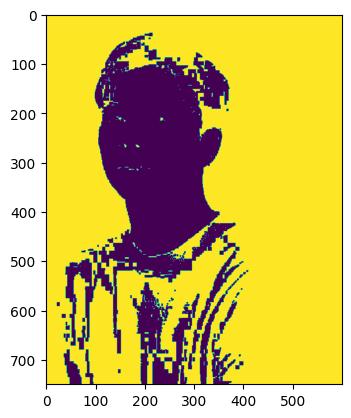

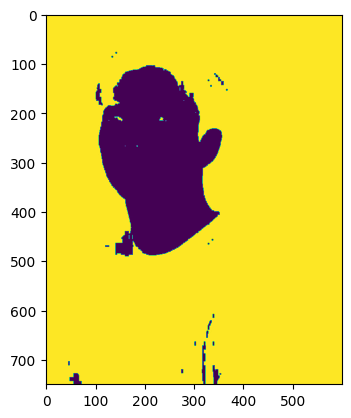

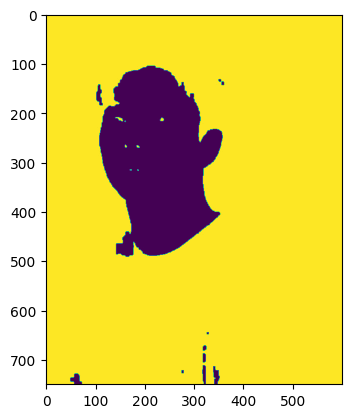

In [59]:
###
# 출력을 위한 함수 따로 만들어야할듯
path = "/content"

HSV_path = path + "/1_HSV.jpg"
image1 = Image.open(HSV_path)
YCbCr_path = path + "/2_YCbCr.jpg"
image2 = Image.open(YCbCr_path)
result_path = path + "/3_global_result.jpg"
image3 = Image.open(result_path)

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()

## (3) 퍼스널 컬러 라벨링